<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_08_FFN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# Import the dataset (it comes with colab)
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")
# Extract labels (number IDs) and remove from the data
labels = data[:,0]
data = data[:,1:]
print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [3]:
# We will use the normalized data
dataNorm = data/np.max(data)
# Step 1: Conver the data into Tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64 (integers)

# Step2: Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Optimizers and Learning Rate

Check the performance of three different optimizers: SGD, RMSProp and Adam, and 6 different learning rates, from 0.0001 to 0.1 in 6 log steps

In [20]:
# Create a class for the model
def createTheMNISTNet(optimizerAlgo, learningrate):

    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784,64)

            # Hidden Layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # Output Layer
            self.output = nn.Linear(32,10)
        
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # Create a model instance
    net = MnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimization function
    optimfun = getattr(torch.optim,optimizerAlgo)
    optimizer = optimfun(net.parameters(), lr = learningrate)

    return net, lossfun, optimizer

In [21]:
# Function to train the model
def function2TrainTheModel(optimizerAlgo, learningrate):

    # Define the number of epochs
    numepochs = 100

    # Create a new model
    net, lossfun, optimizer = createTheMNISTNet(optimizerAlgo, learningrate)

    #Initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Loop over the training batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy from this particular batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        # End of batch loop

        # Train and loss for single epoch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        # Calculate test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        losses[epochi,1] = lossfun(yHat,y).item()
    # End of epoch
    return trainAcc, testAcc, losses, net

In [24]:
# Run the tests
# Define the variables
learningRate = np.logspace(np.log10(0.0001), np.log10(0.1), 6)
optimType = ["SGD", "RMSprop", "Adam"]

# Initialize the performance Matrix
finalPerformance = np.zeros((2, len(learningRate), len(optimType)))

for idx_o, opto in enumerate(optimType):
    for idx_l, lr in enumerate(learningRate):
        trainAcc, testAcc, losses, net = function2TrainTheModel(opto, lr)
        finalPerformance[0, idx_l, idx_o] = np.mean(trainAcc[-10:])
        finalPerformance[1, idx_l, idx_o] = np.mean(testAcc[-10:])

        # Print a message to let us know where it is
        print(f"Finished {idx_o+1} out of {len(optimType)} optimizers and {idx_l+1} out of {len(learningRate)} learning rate")

Finished 1 out of 3 optimizers and 1 out of 6 learning rate
Finished 1 out of 3 optimizers and 2 out of 6 learning rate
Finished 1 out of 3 optimizers and 3 out of 6 learning rate
Finished 1 out of 3 optimizers and 4 out of 6 learning rate
Finished 1 out of 3 optimizers and 5 out of 6 learning rate
Finished 1 out of 3 optimizers and 6 out of 6 learning rate
Finished 2 out of 3 optimizers and 1 out of 6 learning rate
Finished 2 out of 3 optimizers and 2 out of 6 learning rate
Finished 2 out of 3 optimizers and 3 out of 6 learning rate
Finished 2 out of 3 optimizers and 4 out of 6 learning rate
Finished 2 out of 3 optimizers and 5 out of 6 learning rate
Finished 2 out of 3 optimizers and 6 out of 6 learning rate
Finished 3 out of 3 optimizers and 1 out of 6 learning rate
Finished 3 out of 3 optimizers and 2 out of 6 learning rate
Finished 3 out of 3 optimizers and 3 out of 6 learning rate
Finished 3 out of 3 optimizers and 4 out of 6 learning rate
Finished 3 out of 3 optimizers and 5 out

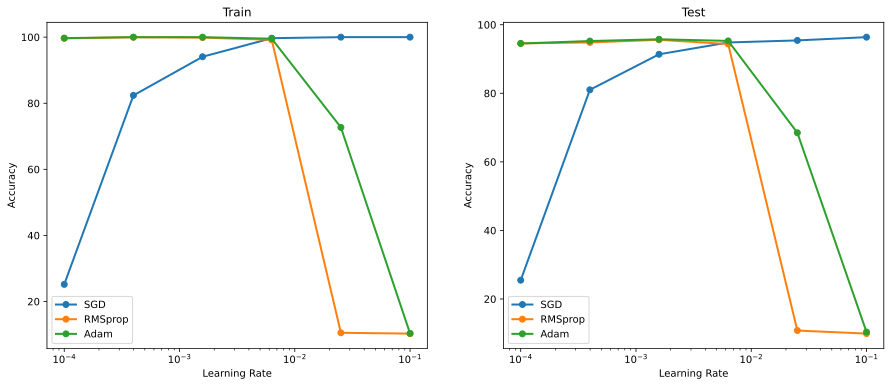

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(learningRate, finalPerformance[0,:,:], "o-", linewidth=2)
ax[1].plot(learningRate, finalPerformance[1,:,:], "o-", linewidth=2)

for i in range(2):
    ax[i].legend(optimType)
    ax[i].set_xscale("log")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Learning Rate")
    ax[i].set_title(["Train" if i==0 else "Test"][0])

plt.show()

In [28]:
# Maximum test Accuracy
np.max(finalPerformance[1,:,:])

96.375

# Scrambled MNIST

Explore whether FFNs use spatial information present in the images during learning. This is a kind of introduction to Convolutional Neural Networks we will see later. 

Scramble means to take the original image of a digit from MNIST and randomly scramble the pixels. The remaping is constant for every image.

We will use the normalized data used in the previous section and change the code accordingly.

In [30]:
# Scramble the images
## Randomly scramble the data by preserving the re-ordering of each image
scr_coord = np.random.permutation(data.shape[1])
scrambled = dataNorm[:,scr_coord]

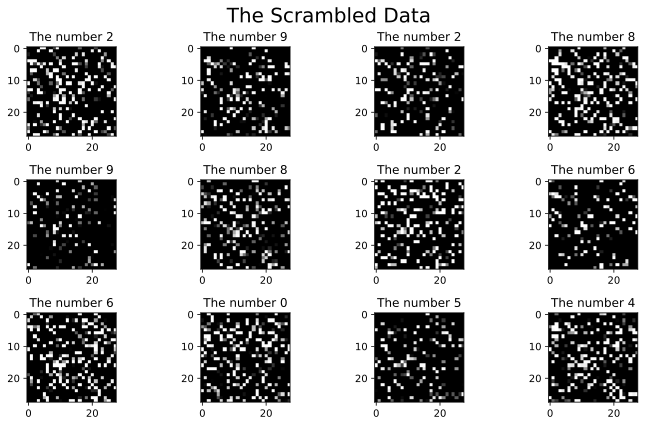

In [33]:
# Show a few random images
fig,ax = plt.subplots(3,4,figsize=(10,6))

for axs in ax.flatten():
    # pick random image
    randimg2show = np.random.randint(0,high=data.shape[0])

    # Create the image by reshaping it
    img = np.reshape(scrambled[randimg2show,:],(28,28))
    axs.imshow(img,cmap="gray")

    # Title
    axs.set_title("The number {:.0f}".format(labels[randimg2show]))

plt.suptitle("The Scrambled Data", fontsize=20)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [35]:
from ssl import TLSVersion
# Create the train-test set
dataT = torch.tensor(scrambled).float()
labelsT = torch.tensor(labels).long()

# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size=0.9)

# Convert into PyTorch Datasets
train_dataP = TensorDataset(train_data, train_labels)
test_dataP = TensorDataset(test_data, test_labels)

# Translate to DataLoaders
batchsize = 32
train_loader = DataLoader(train_dataP, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataP, batch_size=test_dataP.tensors[0].shape[0])

In [36]:
# Create a function for model class
def createTheMNISTNet():
    
    # define the class
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784,64)

            # Hidden Layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # Output Layer
            self.output = nn.Linear(32,10)
        
        # Define the forward pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)
    
    # Create model instance
    net = MnistNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)

    # Wrap it up
    return net, lossfun, optimizer

In [37]:
# Create function to train the model
def function2TrainTheModel():

    # Define number of epochs
    numepochs = 100

    # Create New Model
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []

        # iterate over the batches
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Losses and accuracy for each batch
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # End of the batch

        # Train accuracy and loss for each epoch
        trainAcc.append(np.mean(batchAcc))
        losses[epochi,0] = np.mean(batchLoss)

        # Testing
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        # Test Loss
        losses[epochi,1] = lossfun(yHat,y).item()
    # End of epochs
    # Return the whole thing
    return trainAcc, testAcc, losses, net

In [38]:
# Run the model
trainAcc, testAcc, losses, net = function2TrainTheModel()

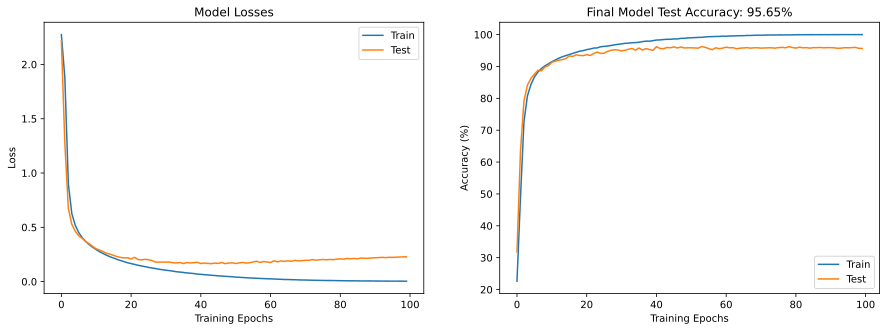

In [39]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(['Train','Test'])
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()
# This is damn funny. How doest the model find the patterns!? FFNs do not care about spatial arrangements.